In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

from recnn.preprocessing import rewrite_content
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract
from recnn.preprocessing import sequentialize_by_pt
from recnn.preprocessing import randomize

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

# Plotting functions

In [3]:
from recnn.preprocessing import sequentialize_by_pt

def load_tf(filename_train, preprocess=None):
    # Make training data
    print("Loading training data...")

    fd = open(filename_train, "rb")
    X, y = pickle.load(fd)
    fd.close()

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [rewrite_content(jet) for jet in X]
    
    if preprocess:
        X = [preprocess(jet) for jet in X]
        
    X = [extract(permute_by_pt(jet)) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))
    
    return tf

def load_test(tf, filename_test, preprocess=None, cropping=True):
    # Make test data 
    print("Loading test data...")

    fd = open(filename_test, "rb")
    X, y = pickle.load(fd)
    fd.close()
    y = np.array(y)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [rewrite_content(jet) for jet in X]
    
    if preprocess:
        X = [preprocess(jet) for jet in X]
        
    X = [extract(permute_by_pt(jet)) for jet in X]

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
    
    if not cropping:
        return X, y
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    
    # Weights for flatness in pt
    pdf, edges = np.histogram([j["pt"] for j in X], density=True, range=[250, 300], bins=100)
    pts = [j["pt"] for j in X]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
        
    return X, y, inv_w

In [4]:
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated
from recnn.recnn import grnn_predict_simple_join


def predict(X, filename, func=grnn_predict_simple):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return y_pred


def evaluate_models(X, y, w, pattern, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
            
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
         
    print("Mean ROC AUC = %.4f" % np.mean(rocs))
        
    return rocs, fprs, tprs

def build_rocs(prefix_train, prefix_test, model_pattern, preprocess=None, gated=False):
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix_train, preprocess=preprocess)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix_test, preprocess=preprocess) 
    
    if not gated:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % model_pattern)
    else:
        rocs, fprs, tprs = evaluate_models(X, y, w, 
                                           "../models/jet-study-2/model-w-g-%s-[0-9]*.pickle" % model_pattern, func=grnn_predict_gated)
        
    return rocs, fprs, tprs

In [39]:
def remove_outliers(rocs, fprs, tprs):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)

    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)

    inv_fprs = np.array(inv_fprs)
    scores = inv_fprs[:, 225]
    
    p25 = np.percentile(scores, 1 / 6. * 100.)
    p75 = np.percentile(scores, 5 / 6. * 100)
    
    robust_mean = np.mean([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    robust_std = np.std([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    
    indices = [i for i in range(len(scores)) if robust_mean - 3*robust_std <= scores[i] <= robust_mean + 3*robust_std]
    
    new_r, new_f, new_t = [], [], []
    
    for i in indices:
        new_r.append(rocs[i])
        new_f.append(fprs[i])
        new_t.append(tprs[i])
    
    return new_r, new_f, new_t


def report_score(rocs, fprs, tprs, label, latex=False, input="particles", short=False):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                       np.mean(rocs), 
                                                                       np.std(rocs),
                                                                       np.mean(inv_fprs[:, 225]),
                                                                       np.std(inv_fprs[:, 225])))
    else:
        if not short:
            print("%10s \t& %30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (input,
                   label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
        else:
            print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (label,
                   np.mean(rocs), 
                   np.std(rocs),
                   np.mean(inv_fprs[:, 225]),
                   np.std(inv_fprs[:, 225])))
        
def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("TPR")
    plt.ylabel("1 / FPR")
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Count parameters

In [6]:
def count(params):
    def _count(thing):
        if isinstance(thing, list):
            c = 0
            for stuff in thing:
                c += _count(stuff)
            return c 

        elif isinstance(thing, np.ndarray):
            return np.prod(thing.shape)
    
    c = 0
    for k, v in params.items():
        c += _count(v)
    return c
    
# Simple vs gated
fd = open("../models/jet-study-2/model-w-s-antikt-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Simple =", count(params))   

fd = open("../models/jet-study-2/model-w-g-antikt-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Gated =", count(params))

('Simple =', 8481)
('Gated =', 48761)


# Generate all ROCs

In [ ]:
for pattern, gated in [
        # Simple
        ## Particles
        ("antikt-kt", False),
        ("antikt-cambridge", False),
        ("antikt-antikt", False),
        ("antikt-random", False),
        ("antikt-seqpt", False),
        ("antikt-seqpt-reversed", False),
        ## Towers
        ("antikt-kt-delphes", False),
        ("antikt-cambridge-delphes", False),
        ("antikt-antikt-delphes", False),
        ("antikt-random-delphes", False),
        ("antikt-seqpt-delphes", False),
        ("antikt-seqpt-reversed-delphes", False),
        ## Images
        ("antikt-kt-images", False),

        # Gated
        ## Particles
        ("antikt-kt", True),
        ("antikt-antikt", True),
        ("antikt-seqpt", True),
        ("antikt-seqpt-reversed", True),
        ## Towers
        ("antikt-kt-delphes", True),
        ("antikt-antikt-delphes", True),
        ("antikt-seqpt-delphes", True),
        ("antikt-seqpt-reversed-delphes", True),
        ## Images
        ("antikt-kt-images", True)
    ]:
    r, f, t = build_rocs(pattern, pattern, pattern, gated=gated)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

# Table

In [40]:
for pattern, gated, label in [
        # Simple
        ## Particles
        ("antikt-kt", False, "RNN $k_t$"),
        ("antikt-cambridge", False, "RNN C/A"),
        ("antikt-antikt", False, "RNN anti-$k_t$"),
        ("antikt-random", False, "RNN random"),
        ("antikt-seqpt", False, "RNN asc-$p_T$"),
        ("antikt-seqpt-reversed", False, "RNN desc-$p_T$"),
        ## Towers
        ("antikt-kt-delphes", False, "RNN $k_t$"),
        ("antikt-cambridge-delphes", False, "RNN C/A"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$"),
        ("antikt-random-delphes", False, "RNN random"),
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$"),
        ## Images
        ("antikt-kt-images", False, "RNN $k_t$"),

        # Gated
        ## Particles
        ("antikt-kt", True, "RNN $k_t$ (gated)"),
        ("antikt-antikt", True, "RNN anti-$k_t$ (gated)"),
        ("antikt-seqpt", True, "RNN asc-$p_T$ (gated)"),
        ("antikt-seqpt-reversed", True, "RNN desc-$p_T$ (gated)"),
        ## Towers
        ("antikt-kt-delphes", True, "RNN $k_t$ (gated)"),
        ("antikt-antikt-delphes", True, "RNN anti-$k_t$ (gated)"),
        ("antikt-seqpt-delphes", True, "RNN asc-$p_T$ (gated)"),
        ("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$ (gated)"),
    
        # Images
        ("antikt-kt-images", False, "RNN $k_t$"),
        ("antikt-kt-images", True, "RNN $k_t$ (gated)")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label, 
                 latex=True, 
                 input="particles" if "delphes" not in pattern and "images" not in pattern else "towers")

 particles 	&                      RNN $k_t$ 	& 0.9191 $\pm$ 0.0006 	& 69.1 $\pm$ 1.9 \\
 particles 	&                        RNN C/A 	& 0.9198 $\pm$ 0.0008 	& 69.1 $\pm$ 3.7 \\
 particles 	&                 RNN anti-$k_t$ 	& 0.9105 $\pm$ 0.0013 	& 52.6 $\pm$ 3.8 \\
 particles 	&                     RNN random 	& 0.9128 $\pm$ 0.0007 	& 51.5 $\pm$ 1.7 \\
 particles 	&                  RNN asc-$p_T$ 	& 0.9137 $\pm$ 0.0031 	& 53.1 $\pm$ 7.4 \\
 particles 	&                 RNN desc-$p_T$ 	& 0.9195 $\pm$ 0.0009 	& 71.2 $\pm$ 3.7 \\
    towers 	&                      RNN $k_t$ 	& 0.8819 $\pm$ 0.0009 	& 24.5 $\pm$ 0.5 \\
    towers 	&                        RNN C/A 	& 0.8841 $\pm$ 0.0009 	& 24.6 $\pm$ 0.7 \\
    towers 	&                 RNN anti-$k_t$ 	& 0.8750 $\pm$ 0.0016 	& 22.7 $\pm$ 0.8 \\
    towers 	&                     RNN random 	& 0.8716 $\pm$ 0.0011 	& 20.7 $\pm$ 0.4 \\
    towers 	&                  RNN asc-$p_T$ 	& 0.8846 $\pm$ 0.0009 	& 26.4 $\pm$ 0.7 \\
    towers 	&        

# Plots

              RNN $k_t$ (simple)	ROC AUC=0.9191+-0.00	1/FPR@TPR=0.5=69.07+-1.93
               RNN $k_t$ (gated)	ROC AUC=0.9202+-0.00	1/FPR@TPR=0.5=75.22+-2.53


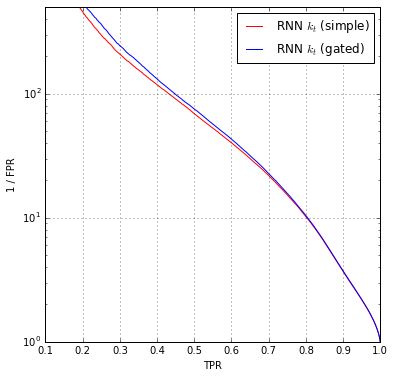

In [44]:
# Simple vs gated
for pattern, gated, label, color in [
        ("antikt-kt", False, "RNN $k_t$ (simple)", "r"),
        ("antikt-kt", True, "RNN $k_t$ (gated)", "b")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       RNN $k_t$	ROC AUC=0.9191+-0.00	1/FPR@TPR=0.5=69.07+-1.93
                         RNN C/A	ROC AUC=0.9198+-0.00	1/FPR@TPR=0.5=69.11+-3.74
                  RNN anti-$k_t$	ROC AUC=0.9105+-0.00	1/FPR@TPR=0.5=52.65+-3.75
                   RNN asc-$p_T$	ROC AUC=0.9137+-0.00	1/FPR@TPR=0.5=53.12+-7.39
                  RNN desc-$p_T$	ROC AUC=0.9195+-0.00	1/FPR@TPR=0.5=71.16+-3.73
                      RNN random	ROC AUC=0.9128+-0.00	1/FPR@TPR=0.5=51.54+-1.67


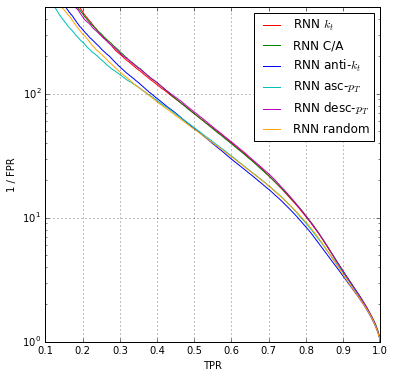

In [45]:
# Topologies (particles, simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "RNN $k_t$", "r"), 
        ("antikt-cambridge", False, "RNN C/A", "g"),
        ("antikt-antikt", False, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt", False, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", False, "RNN desc-$p_T$", "m"),
        ("antikt-random", False, "RNN random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       RNN $k_t$	ROC AUC=0.8819+-0.00	1/FPR@TPR=0.5=24.47+-0.53
                         RNN C/A	ROC AUC=0.8841+-0.00	1/FPR@TPR=0.5=24.55+-0.66
                  RNN anti-$k_t$	ROC AUC=0.8750+-0.00	1/FPR@TPR=0.5=22.68+-0.84
                   RNN asc-$p_T$	ROC AUC=0.8846+-0.00	1/FPR@TPR=0.5=26.44+-0.66
                  RNN desc-$p_T$	ROC AUC=0.8849+-0.00	1/FPR@TPR=0.5=25.50+-0.59
                      RNN random	ROC AUC=0.8716+-0.00	1/FPR@TPR=0.5=20.67+-0.38


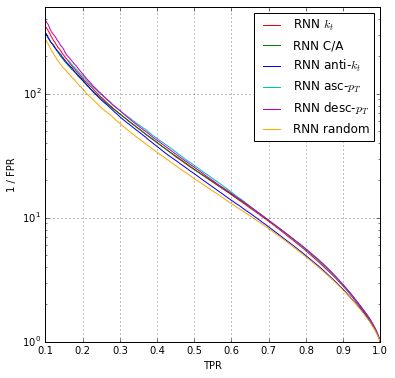

In [48]:
# Topologies (towers, simple)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", False, "RNN $k_t$", "r"), 
        ("antikt-cambridge-delphes", False, "RNN C/A", "g"),
        ("antikt-antikt-delphes", False, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", False, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", False, "RNN desc-$p_T$", "m"),
        ("antikt-random-delphes", False, "RNN random", "orange")
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       RNN $k_t$	ROC AUC=0.9202+-0.00	1/FPR@TPR=0.5=75.22+-2.53
                  RNN anti-$k_t$	ROC AUC=0.9165+-0.00	1/FPR@TPR=0.5=69.34+-3.21
                   RNN asc-$p_T$	ROC AUC=0.9146+-0.00	1/FPR@TPR=0.5=55.64+-11.90
                  RNN desc-$p_T$	ROC AUC=0.9219+-0.00	1/FPR@TPR=0.5=84.24+-3.06


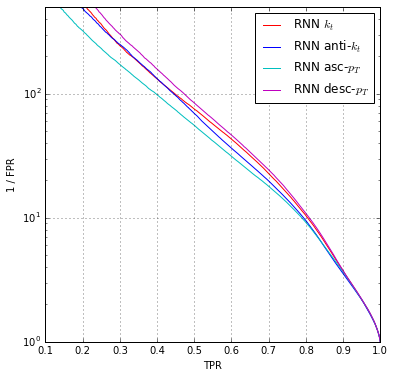

In [49]:
# Topologies (particles, gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "RNN $k_t$", "r"), 
        ("antikt-antikt", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       RNN $k_t$	ROC AUC=0.8833+-0.00	1/FPR@TPR=0.5=25.68+-0.39
                  RNN anti-$k_t$	ROC AUC=0.8816+-0.00	1/FPR@TPR=0.5=24.73+-0.47
                   RNN asc-$p_T$	ROC AUC=0.8861+-0.00	1/FPR@TPR=0.5=27.54+-0.82
                  RNN desc-$p_T$	ROC AUC=0.8875+-0.00	1/FPR@TPR=0.5=27.86+-0.55


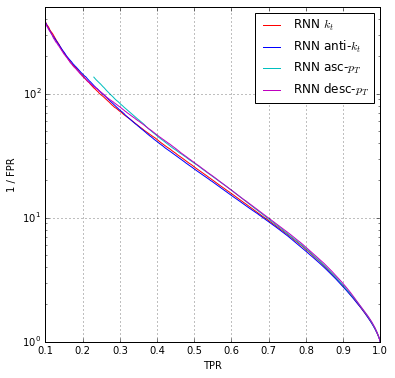

In [50]:
# Topologies (towers, gated)
for pattern, gated, label, color in [
        ("antikt-kt-delphes", True, "RNN $k_t$", "r"), 
        ("antikt-antikt-delphes", True, "RNN anti-$k_t$", "b"), 
        ("antikt-seqpt-delphes", True, "RNN asc-$p_T$", "c"),
        ("antikt-seqpt-reversed-delphes", True, "RNN desc-$p_T$", "m"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       particles	ROC AUC=0.9191+-0.00	1/FPR@TPR=0.5=69.07+-1.93
                          towers	ROC AUC=0.8819+-0.00	1/FPR@TPR=0.5=24.47+-0.53
                          images	ROC AUC=0.8340+-0.00	1/FPR@TPR=0.5=12.85+-0.42


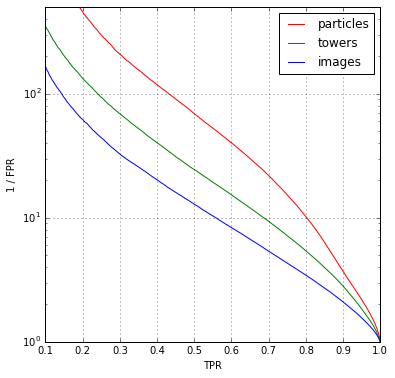

In [51]:
# Particles vs towers vs images (simple)
for pattern, gated, label, color in [
        ("antikt-kt", False, "particles", "r"), 
        ("antikt-kt-delphes", False, "towers", "g"),
        ("antikt-kt-images", False, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

                       particles	ROC AUC=0.9202+-0.00	1/FPR@TPR=0.5=75.22+-2.53
                          towers	ROC AUC=0.8833+-0.00	1/FPR@TPR=0.5=25.68+-0.39
                          images	ROC AUC=0.8296+-0.00	1/FPR@TPR=0.5=12.51+-0.30


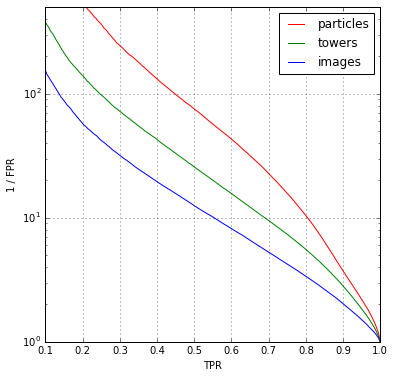

In [52]:
# Particles vs towers vs images (gated)
for pattern, gated, label, color in [
        ("antikt-kt", True, "particles", "r"), 
        ("antikt-kt-delphes", True, "towers", "g"),
        ("antikt-kt-images", True, "images", "b"), 
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s.pickle" % ("s" if not gated else "g", pattern), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

# Trimming

In [ ]:
for pattern_train, pattern_test, gated in [
        ("antikt-kt", "antikt-kt", False),
        ("antikt-kt", "antikt-kt-trimmed", False),
        ("antikt-kt-trimmed", "antikt-kt-trimmed", False),
        ("antikt-kt-trimmed", "antikt-kt", False),
    ]:
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

                  $k_t$ on $k_t$	ROC AUC=0.9191+-0.00	1/FPR@TPR=0.5=69.07+-1.93
          $k_t$ on $k_t$-trimmed	ROC AUC=0.8956+-0.00	1/FPR@TPR=0.5=28.79+-1.25
  $k_t$-trimmed on $k_t$-trimmed	ROC AUC=0.9039+-0.00	1/FPR@TPR=0.5=33.34+-1.87
          $k_t$-trimmed on $k_t$	ROC AUC=0.8900+-0.01	1/FPR@TPR=0.5=37.28+-5.95


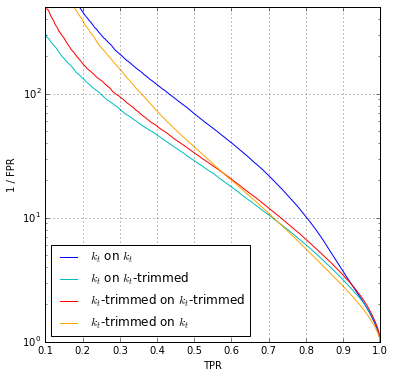

In [53]:
for pattern_train, pattern_test, gated, label, color in [
        ("antikt-kt", "antikt-kt", False, "$k_t$ on $k_t$", "b"),
        ("antikt-kt", "antikt-kt-trimmed", False, "$k_t$ on $k_t$-trimmed", "c"),
        ("antikt-kt-trimmed", "antikt-kt-trimmed", False, "$k_t$-trimmed on $k_t$-trimmed", "r"),
        ("antikt-kt-trimmed", "antikt-kt", False, "$k_t$-trimmed on $k_t$", "orange"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    plot_rocs(r, f, t, label=label, color=color)
    report_score(r, f, t, label=label)
    
plot_show()

# Colinear splits

In [ ]:
from functools import partial
from recnn.preprocessing import sequentialize_by_pt

preprocess_seqpt = partial(sequentialize_by_pt, reverse=False)
preprocess_seqpt_rev = partial(sequentialize_by_pt, reverse=True)

for pattern_train, pattern_test, gated, preprocess in [
        # kt
        ("antikt-kt", "antikt-kt-colinear1", False, None),
        ("antikt-kt", "antikt-kt-colinear10", False, None),
        ("antikt-kt", "antikt-kt-colinear1-max", False, None),
        ("antikt-kt", "antikt-kt-colinear10-max", False, None),
    
        # asc-pt
        ("antikt-seqpt", "antikt-kt-colinear1", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear10", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear1-max", False, preprocess_seqpt),
        ("antikt-seqpt", "antikt-kt-colinear10-max", False, preprocess_seqpt),
    
        # desc-pt
        ("antikt-seqpt-reversed", "antikt-kt-colinear1", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear1-max", False, preprocess_seqpt_rev),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10-max", False, preprocess_seqpt_rev),
    ]:
    
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated, preprocess=preprocess)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

In [54]:
for pattern_train, pattern_test, gated, label in [
        # kt
        ("antikt-kt", "antikt-kt-colinear1", False, "$k_t$ colinear1"),
        ("antikt-kt", "antikt-kt-colinear10", False, "$k_t$ colinear10"),
        ("antikt-kt", "antikt-kt-colinear1-max", False, "$k_t$ colinear1-max"),
        ("antikt-kt", "antikt-kt-colinear10-max", False, "$k_t$ colinear10-max"),
    
        # asc-pt
        ("antikt-seqpt", "antikt-kt-colinear1", False, "asc-$p_T$ colinear1"),
        ("antikt-seqpt", "antikt-kt-colinear10", False, "asc-$p_T$ colinear10"),
        ("antikt-seqpt", "antikt-kt-colinear1-max", False, "asc-$p_T$ colinear1-max"),
        ("antikt-seqpt", "antikt-kt-colinear10-max", False, "asc-$p_T$ colinear10-max"),
    
        # desc-pt
        ("antikt-seqpt-reversed", "antikt-kt-colinear1", False, "desc-$p_T$ colinear1"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10", False, "desc-$p_T$ colinear10"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear1-max", False, "desc-$p_T$ colinear1-max"),
        ("antikt-seqpt-reversed", "antikt-kt-colinear10-max", False, "desc-$p_T$ colinear10-max"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label,
                 latex=True, short=True)

               $k_t$ colinear1 	& 0.9190 $\pm$ 0.0006 	& 69.8 $\pm$ 2.3 \\
              $k_t$ colinear10 	& 0.9180 $\pm$ 0.0006 	& 68.1 $\pm$ 2.8 \\
           $k_t$ colinear1-max 	& 0.9191 $\pm$ 0.0006 	& 69.5 $\pm$ 2.8 \\
          $k_t$ colinear10-max 	& 0.9166 $\pm$ 0.0009 	& 66.7 $\pm$ 2.6 \\
           asc-$p_T$ colinear1 	& 0.9136 $\pm$ 0.0031 	& 53.6 $\pm$ 7.6 \\
          asc-$p_T$ colinear10 	& 0.9134 $\pm$ 0.0033 	& 54.3 $\pm$ 7.3 \\
       asc-$p_T$ colinear1-max 	& 0.9137 $\pm$ 0.0032 	& 54.9 $\pm$ 8.1 \\
      asc-$p_T$ colinear10-max 	& 0.9098 $\pm$ 0.0039 	& 50.8 $\pm$ 8.4 \\
          desc-$p_T$ colinear1 	& 0.9194 $\pm$ 0.0010 	& 71.1 $\pm$ 4.4 \\
         desc-$p_T$ colinear10 	& 0.9184 $\pm$ 0.0010 	& 68.7 $\pm$ 4.4 \\
      desc-$p_T$ colinear1-max 	& 0.9197 $\pm$ 0.0009 	& 73.1 $\pm$ 4.5 \\
     desc-$p_T$ colinear10-max 	& 0.9144 $\pm$ 0.0016 	& 63.6 $\pm$ 5.6 \\


# Soft particles

In [ ]:
from functools import partial
from recnn.preprocessing import sequentialize_by_pt

preprocess_seqpt = partial(sequentialize_by_pt, reverse=False)
preprocess_seqpt_rev = partial(sequentialize_by_pt, reverse=True)

for pattern_train, pattern_test, gated, preprocess in [
        ("antikt-kt", "antikt-kt-soft", False, None),
        ("antikt-seqpt", "antikt-kt-soft", False, preprocess_seqpt),
        ("antikt-seqpt-reversed", "antikt-kt-soft", False, preprocess_seqpt_rev),
    ]:
    
    r, f, t = build_rocs(pattern_train, pattern_test, pattern_train, gated=gated, preprocess=preprocess)
    
    # Save
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "wb")
    pickle.dump((r, f, t), fd)
    fd.close()

In [55]:
for pattern_train, pattern_test, gated, label in [
        ("antikt-kt", "antikt-kt-soft", False, "$k_t$ soft"),
        ("antikt-seqpt", "antikt-kt-soft", False, "asc-$p_T$ soft"),
        ("antikt-seqpt-reversed", "antikt-kt-soft", False, "desc-$p_T$ soft"),
    ]:
    
    fd = open("../models/jet-study-2/rocs/rocs-%s-%s-%s.pickle" % 
              ("s" if not gated else "g", pattern_train, pattern_test), "rb")
    r, f, t = pickle.load(fd)
    fd.close()
    
    r, f, t = remove_outliers(r, f, t)
    
    report_score(r, f, t, label=label, latex=True, short=True)

                    $k_t$ soft 	& 0.9185 $\pm$ 0.0006 	& 69.1 $\pm$ 2.4 \\
                asc-$p_T$ soft 	& 0.9130 $\pm$ 0.0032 	& 52.0 $\pm$ 6.1 \\
               desc-$p_T$ soft 	& 0.9194 $\pm$ 0.0010 	& 70.7 $\pm$ 4.6 \\
